In [18]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree
from numba import njit, prange
from scipy.interpolate import interp1d
import matplotlib as mpl
from scipy.optimize import root_scalar
import glob
import agama

from pyMND.forcetree import construct_tree, force_treeevaluate_loop

from rbf.interpolate import KNearestRBFInterpolant
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

time_conv = 977.79222167
G = 43018.7

In [19]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=None, fields=['Coordinates', 'Masses', 'Velocities', 'Acceleration'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_shocks(idx, sim_idx, lvl='lvl3'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output-shocks'
    fname = fname + '/shocks_' + "{:03d}".format(idx) + '.hdf5'
    return h5.File(fname, mode='r')

In [20]:
@njit
def my_mult(mass, vel):
    out = np.zeros((len(mass), 3))
    for i in range(len(mass)):
        out[i][0] = mass[i] * vel[i][0] 
        out[i][1] = mass[i] * vel[i][1]
        out[i][2] = mass[i] * vel[i][2]
    return out

In [21]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang), np.cos(ang),  0.0],
                     [0.0,         0.0,          1.0]])
    pos = np.swapaxes(pos, 0, 1)

    pos = np.matmul(Rmat, pos)
    
#     w[:3,:] = np.matmul(Rmat, w[:3,:])
#     w[3:,:] = np.matmul(Rmat, w[3:,:])

    pos = np.swapaxes(pos, 0, 1)
    return pos

# rotate by bar angle at each time step

def rotate_wlist(wlist, bar_angle_out, idx_list):
    bar_angle = np.mod(bar_angle_out['bar_angle'][idx_list], 2.*np.pi)

    Rwlist = np.zeros(np.shape(wlist))

    for i,idx in enumerate(idx_list):
        Rwlist[i] = rotate_w(wlist[i], -bar_angle[i])
    
    return Rwlist

In [22]:
idx = 425
sn = read_snap(idx, 1, lvl='lvl3', fields=None, parttype=None)
shocks = read_shocks(idx, 1, lvl='lvl3')

In [23]:
# read in the bar position
phase_space_path = '/n/home01/abeane/starbar/plots/phase_space/data'
in_bar_path = '/n/home01/abeane/starbar/plots/in_bar/data'
nchunk = len(glob.glob(phase_space_path + '/phantom-vacuum-Sg20-Rc3.5-lvl3/phase_space_*'))

pos = np.array([]).reshape((0, 3))
in_bar = np.array([])
center = np.array([200., 200., 200.])

for i in tqdm(range(nchunk)):
    ps = h5.File(phase_space_path + '/phantom-vacuum-Sg20-Rc3.5-lvl3/phase_space_phantom-vacuum-Sg20-Rc3.5-lvl3.'+str(i)+'.hdf5',
                 mode='r')
    
    ib = h5.File(in_bar_path + '/in_bar_phantom-vacuum-Sg20-Rc3.5-lvl3/in_bar_phantom-vacuum-Sg20-Rc3.5-lvl3.'+str(i)+'.hdf5',
                 mode='r')

    pos = np.concatenate((pos, ps['PartType2/Coordinates'][idx,:,:]))
    pos = np.concatenate((pos, ps['PartType3/Coordinates'][idx,:,:]))
    pos = np.concatenate((pos, ps['PartType4/Coordinates'][idx,:,:]))
    
    in_bar = np.concatenate((in_bar, ib['in_bar'][idx]))
    
    bar_angle = ib['bar_angle'][idx]
    
    ps.close()
    ib.close()

pos = pos - center
pos = rotate_pos(pos, -bar_angle)


    

A Jupyter Widget

In [24]:
# bar_pos = pos[np.where(np.logical_not(in_bar))]
key = np.where(in_bar)[0]
bar_pos = pos[key]

key = np.where(np.logical_not(in_bar))[0]
not_bar_pos = pos[key]

bar_mass = np.full(len(bar_pos), sn.MassTable[2].value)

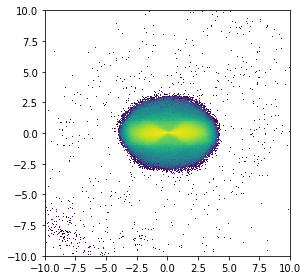

In [25]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = bar_pos[:,0]
y = bar_pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


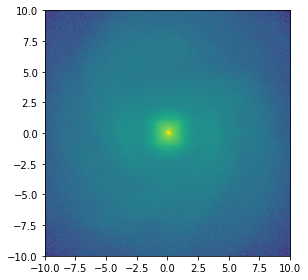

In [26]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = not_bar_pos[:,0]
y = not_bar_pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


In [27]:
gas_pos = sn.part0.pos.value - center
gas_pos = rotate_pos(gas_pos, -bar_angle)
gas_mass = sn.part0.mass.value

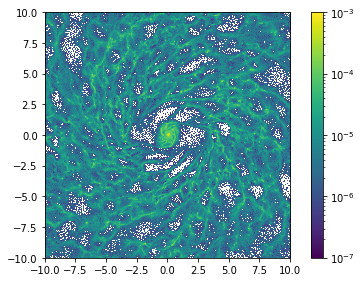

In [28]:
nres = 256

range_xy = [[-10, 10], [-10, 10]]

x = gas_pos[:,0]
y = gas_pos[:,1]
weights = gas_mass
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=weights)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=1E-7, vmax=1E-3, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()
fig.colorbar(im)

plt.show()


In [40]:
shock_pos = np.array(shocks['Coordinates']) - center
shock_pos = rotate_pos(shock_pos, -bar_angle)
shock_mass = np.array(shocks['Volume']) * np.array(shocks['Density'])

shock_dens = np.array(shocks['Density'])
shock_dens[shocks['Machnumber'] == 0.0] = 0.0

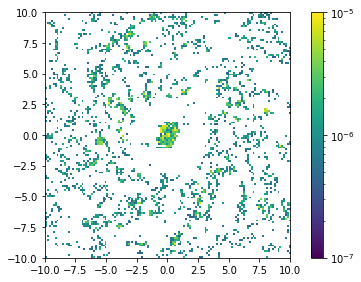

In [30]:
nres = 128

mach_cut = 0.0
key = np.array(shocks['Machnumber']) > mach_cut

range_xy = [[-10, 10], [-10, 10]]

x = shock_pos[:,0][key]
y = shock_pos[:,1][key]
weights = shock_mass[key]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy, weights=weights)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower', vmin=1E-7, vmax=1E-5, norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()
fig.colorbar(im)

plt.show()


In [59]:

gas_pos = sn.part0.pos.value - center
gas_pos = rotate_pos(gas_pos, -bar_angle)

key_sort = np.argsort(sn.part0.id)
gas_pos = gas_pos[key_sort]

dens = sn.part0.rho.value[key_sort]
SFR = sn.part0.sfr[key_sort]

shock_dens = np.array(shocks['Density'])
shock_dens[shocks['Machnumber'] == 0.0] = 0.0
shock_sort = np.argsort(shocks['ID'])
shock_dens = shock_dens[shock_sort]

tree = cKDTree(gas_pos)

In [60]:
nres = 4096
from numba import njit

@njit
def create_plot_pos(x, y, nres):
    plot_pos = np.zeros((nres*nres, 3))
    for i in range(len(x)):
        for j in range(len(y)):
            plot_pos[i*nres + j][0]=x[i][0]
            plot_pos[i*nres + j][1]=y[0][j]

    return plot_pos

x, y = np.meshgrid(np.linspace(-15, 15, nres), np.linspace(-15, 15, nres), indexing='ij')
plot_pos = create_plot_pos(x, y, nres)
# print(plot_pos)

In [61]:
%%time
_, key = tree.query(plot_pos)

CPU times: user 19.2 s, sys: 73.3 ms, total: 19.3 s
Wall time: 19.4 s


In [89]:
shock_dens = np.array(shocks['Density'])
shock_dens[shocks['Machnumber'][:] < 0.1] = 0.0

shock_sort = np.argsort(shocks['ID']) 
shock_dens = shock_dens[shock_sort]

shock_pos_cut = shock_pos[shocks['Machnumber'][:] > 1.0]

xbool = np.abs(shock_pos_cut[:,0]) < 15
ybool = np.abs(shock_pos_cut[:,1]) < 15
zbool = np.abs(shock_pos_cut[:,2]) < 5
tot_bool = np.logical_and(np.logical_and(xbool, ybool), zbool)
shock_pos_cut = shock_pos_cut[tot_bool]


In [93]:
SFR_pos = gas_pos[SFR > 1E-5]

In [77]:
plot_dens = dens[key]
plot_dens_map = np.reshape(plot_dens, (nres, nres))

plot_SFR = SFR[key]
plot_SFR_map = np.reshape(plot_SFR, (nres, nres))

plot_shockdens = shock_dens[key]
plot_shockdens_map = np.reshape(plot_shockdens, (nres, nres))

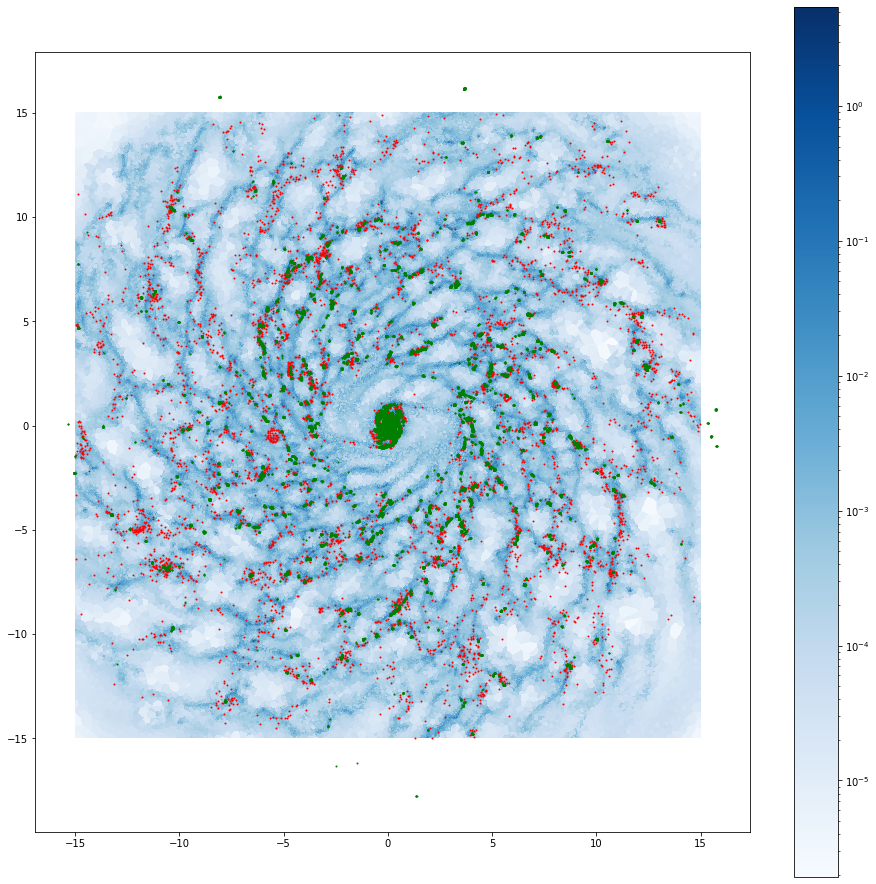

In [96]:


fig, ax = plt.subplots(1, 1, figsize=(16, 16))
extent = [-15, 15, -15, 15]
im = ax.imshow(plot_dens_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap='Blues')
# ax.imshow(plot_SFR_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap='Reds', alpha=1)
ax.scatter(shock_pos_cut[:,0], shock_pos_cut[:,1], s=1, c='r')
ax.scatter(SFR_pos[:,0], SFR_pos[:,1], s=1, c='g')
fig.colorbar(im, ax=ax)
plt.show()

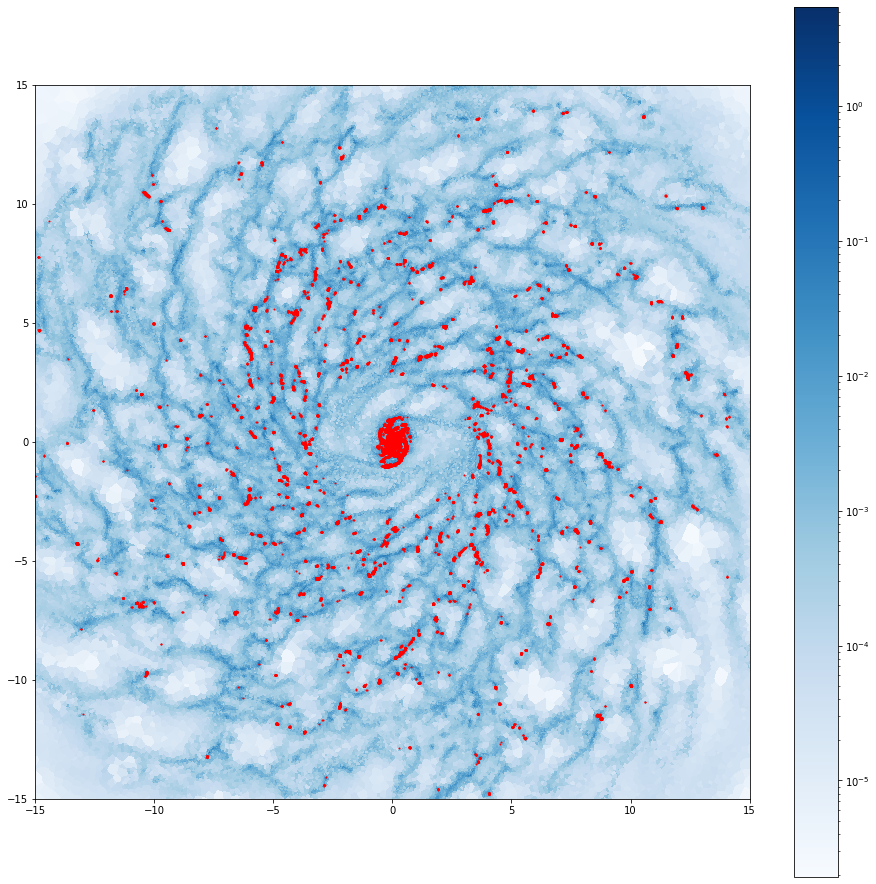

In [95]:


fig, ax = plt.subplots(1, 1, figsize=(16, 16))
extent = [-15, 15, -15, 15]
im = ax.imshow(plot_dens_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap='Blues')
# ax.imshow(plot_SFR_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap='Reds', alpha=1)

ax.scatter(SFR_pos[:,0], SFR_pos[:,1], s=1, c='r')
fig.colorbar(im, ax=ax)
ax.set(xlim=(-15, 15), ylim=(-15, 15))
plt.show()

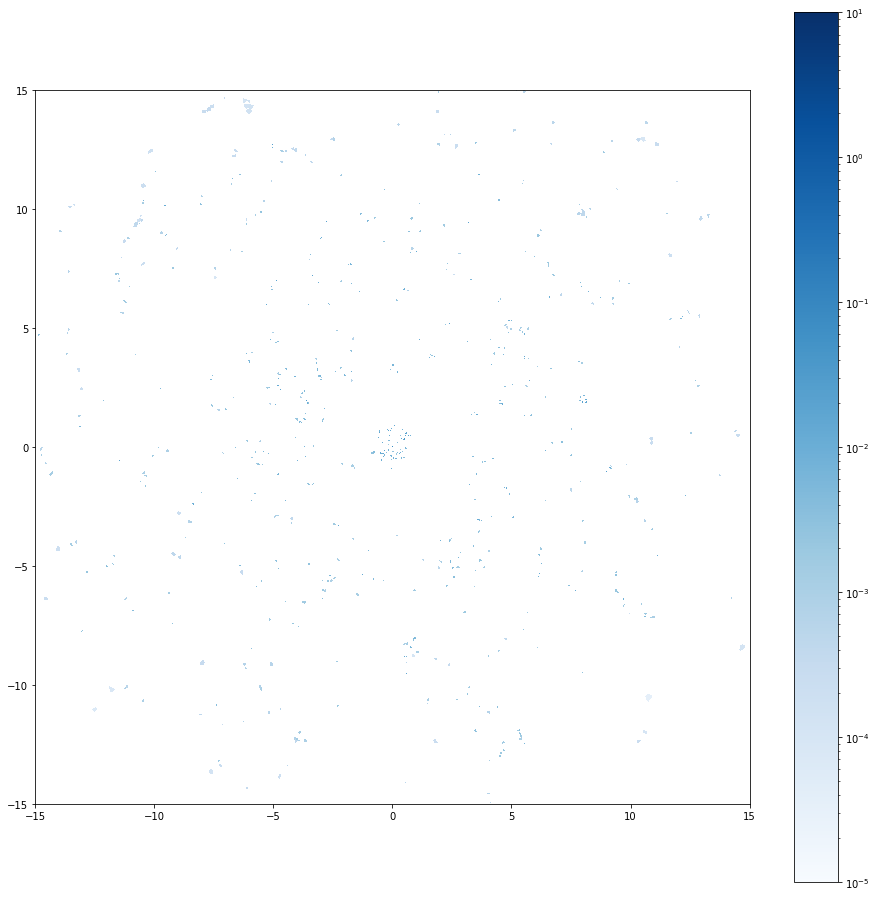

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
extent = [-15, 15, -15, 15]
im = ax.imshow(plot_shockdens_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(vmin=1E-5, vmax=10), cmap='Blues')
# ax.imshow(plot_SFR_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap='Reds', alpha=1)
fig.colorbar(im, ax=ax)
plt.show()

In [44]:
shockdens

NameError: name 'shockdens' is not defined

In [51]:
sn.part0.id

array([36550839, 32868227, 36550846, ..., 32869988, 36553184, 36548459],
      dtype=uint32)

(array([635502]),)